In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [15]:
BATCH_SIZE = 64
RATE = 0.001
EPOCHS = 10

In [4]:
transform_train = transforms.Compose([

    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(10),              #some augmentation

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"training: {len(trainset)}")
print(f"testing: {len(testset)}")

training: 50000
testing: 10000


In [17]:
class  CIFAR10Net(nn.Module):
  def __init__(self):
    super(CIFAR10Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.25)
    self.fc1 = nn.Linear(128 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x= self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 128 * 4 * 4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class SimpleCIFAR10Net(nn.Module):
    def __init__(self):
        super(SimpleCIFAR10Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = SimpleCIFAR10Net().to(device)
print(net)

SimpleCIFAR10Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [20]:
train_loss =[]
train_acc= []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    epoch_accuracy = 100 * correct /total
    train_acc.append(epoch_accuracy)
    train_loss.append(running_loss/len(trainloader))

    print(f'Epoch -> {epoch+1} , accuracy -> {epoch_accuracy:.2f}')
print('the end')

Epoch -> 1 , accuracy -> 50.69
Epoch -> 2 , accuracy -> 61.64
Epoch -> 3 , accuracy -> 65.17
Epoch -> 4 , accuracy -> 67.17
Epoch -> 5 , accuracy -> 68.76
Epoch -> 6 , accuracy -> 72.90
Epoch -> 7 , accuracy -> 74.32
Epoch -> 8 , accuracy -> 75.12
Epoch -> 9 , accuracy -> 76.11
Epoch -> 10 , accuracy -> 76.77
the end


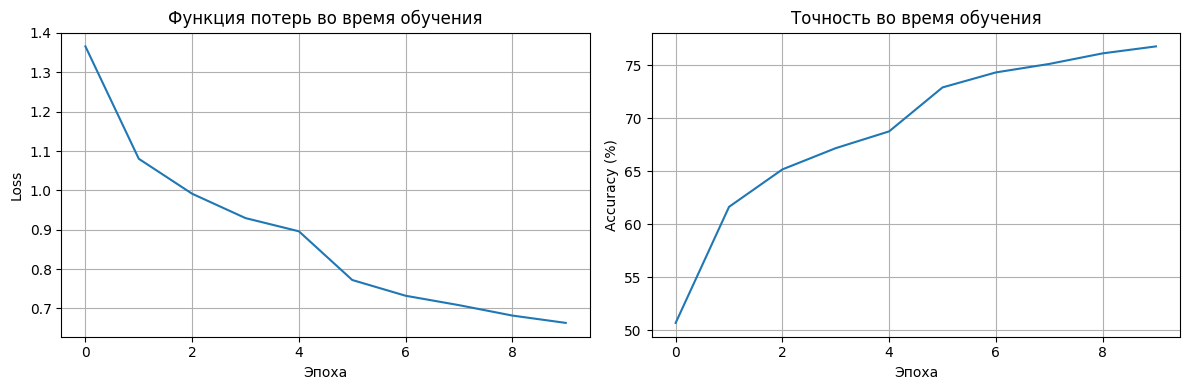

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.title('Точность во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())

print(f'Точность на тестовой выборке: {100 * correct / total:.2f}%')


Точность на тестовой выборке: 73.27%


In [31]:
PATH = './cifar_net.pth'
torch.save(
net.state_dict()
, PATH)

print(f"Модель сохранена в {PATH}")

Модель сохранена в ./cifar_net.pth
